In [ ]:
!nvidia-smi

Thu Nov  7 18:30:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2024-11-07 18:31:12--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  25.2MB/s    in 12s     

2024-11-07 18:31:25 (22.3 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

In [ ]:
len(train_folders)

43

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img


def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(14, 7))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

<ipython-input-15-e5cbae1013c5>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  images = torch.as_tensor(images)


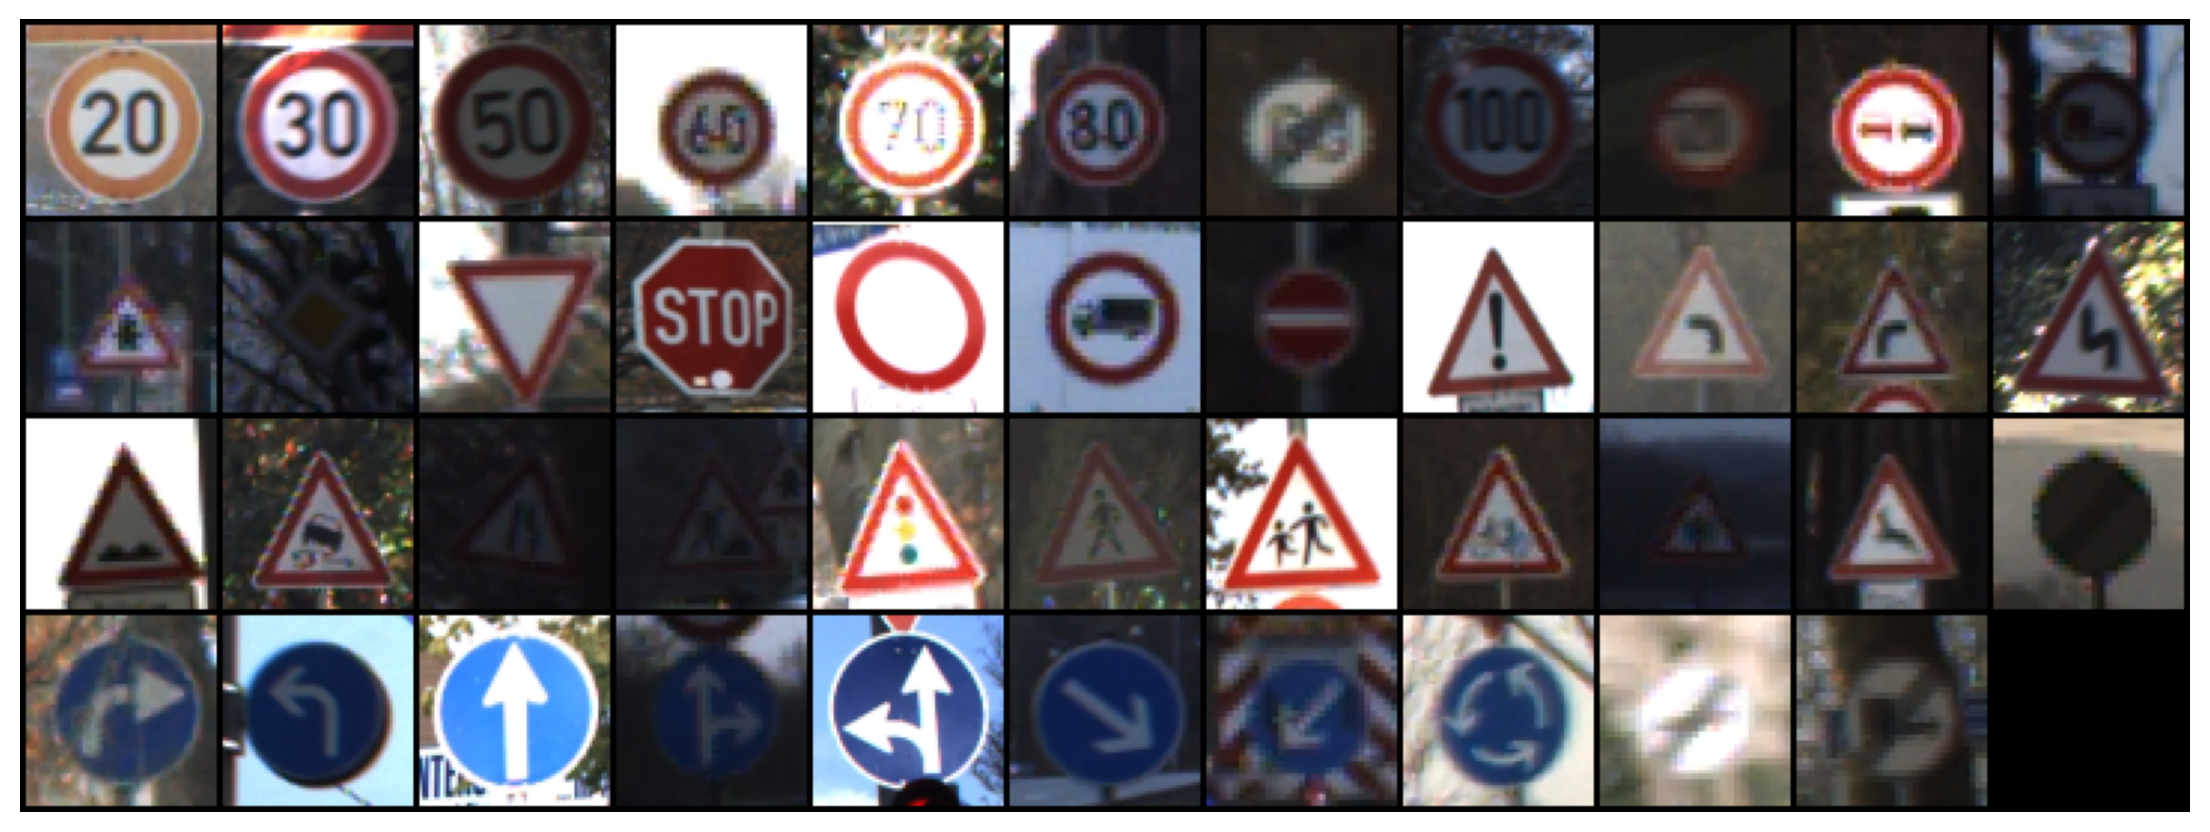

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm'))for tf in train_folders]
show_sign_grid(sample_images)

In [ ]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [19]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [20]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [22]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

In [23]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

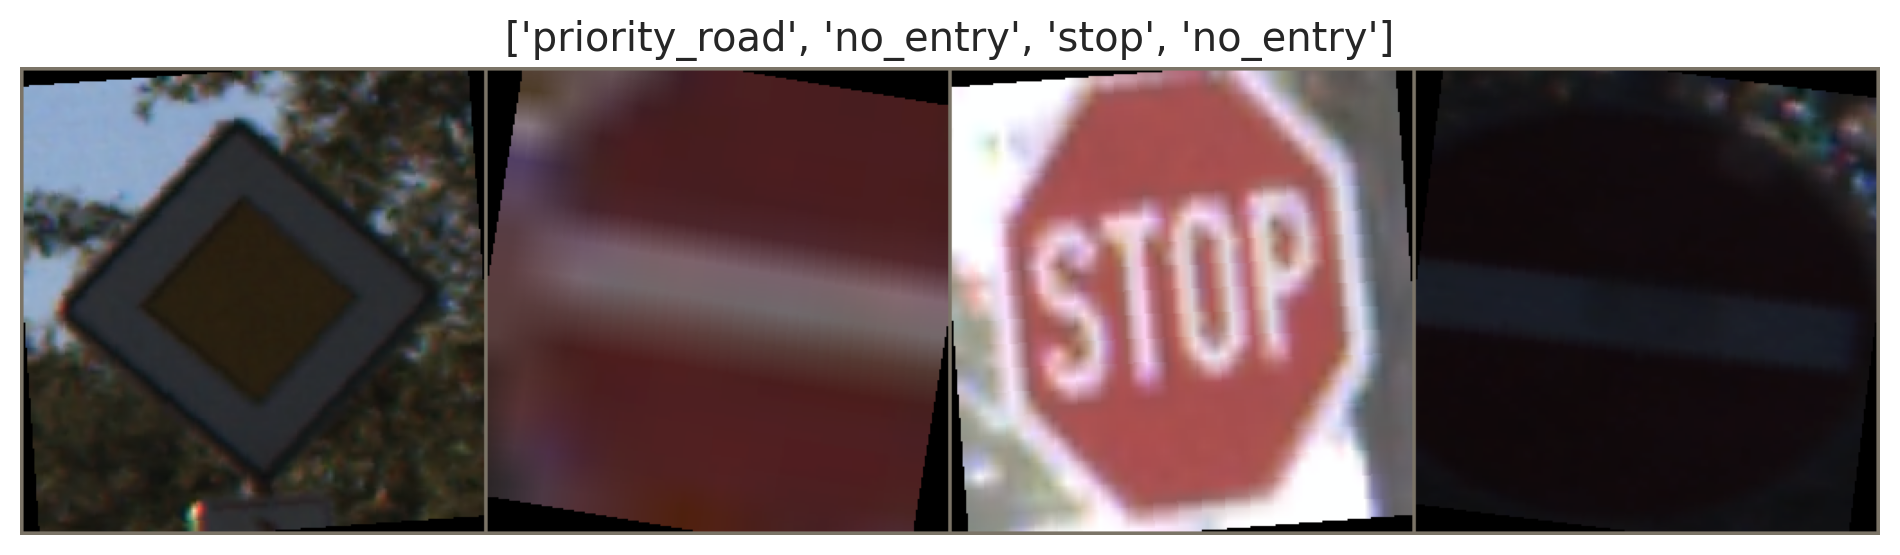

In [27]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [38]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [41]:
base_model = create_model(len(class_names))